# BanaNavigation

### Packages

Import the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), [NumPy](http://www.numpy.org/), and [PyTorch](https://pytorch.org/get-started/locally/).

In [3]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import math
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### Unity Environment

In [3]:
class EnvironmentWrapper(object):    
    """Wrapper to make the unity enviroment more like OpenAI Gym."""
    
    def __init__(self, env):
        """Initialize.
        
        Params
        ======
            env: The unity environment to wrap.
        """
        self.env = env
        self.brain_name = self.env.brain_names[0]
        
        self.action_size = self.env.brains[self.brain_name].vector_action_space_size
        starting_state = self.reset()
        self.state_size = len(starting_state)
        
    def reset(self, train_mode=True):
        env_info = self.env.reset(train_mode=train_mode)[self.brain_name]
        return env_info.vector_observations[0]
    
    def step(self, action):
        # workaround a bug in ml-agents on Windows
        # https://github.com/Unity-Technologies/ml-agents/issues/1448
        action = np.int32(action)

        env_info = self.env.step(action)[self.brain_name] 
        reward = env_info.rewards[0]
        next_state = env_info.vector_observations[0]
        done = env_info.local_done[0]
        
        return next_state, reward, done, env_info

Start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
unity_env = UnityEnvironment(file_name="Banana.app")
```

In [4]:
unity_env = UnityEnvironment(file_name="./environments/Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
banana_env = EnvironmentWrapper(unity_env)

### DQN Training

The training harness for the DQN.

In [5]:
def dqn(dqn_agent, checkpoint_file='./checkpoints/checkpoint.pth', n_episodes=1500, max_t=300, 
        eps_start=1.0, eps_end=0.01, eps_decay=0.995, print_every=100):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    message_printed = False
    
    for i_ep in range(1, n_episodes+1):
        state = banana_env.reset(True)
        score = 0
        
        for t in range(max_t):
            action = dqn_agent.act(state, eps)

            next_state, reward, done, _ = banana_env.step(action)
            
            dqn_agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_ep, np.mean(scores_window)), end="")
        if i_ep % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_ep, np.mean(scores_window)))
        
        if np.mean(scores_window) >= 13.0 and not message_printed:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_ep, np.mean(scores_window)))
            message_printed = True
            
        if np.mean(scores_window) >= 16.0:
            print('\nEnvironment 16+ in {:d} episodes!\tAverage Score: {:.2f}'.format(i_ep, np.mean(scores_window)))
            break
            
            
    torch.save(dqn_agent.qnetwork_online.state_dict(), checkpoint_file)    
    return scores

Plot the epsilon decay by frame.

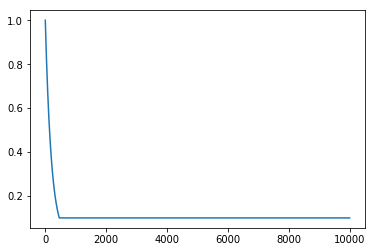

In [5]:
epsilon_function = lambda idx: max(0.1, 1.0 * math.pow(0.995, idx))
plt.plot([epsilon_function(i) for i in range(10000)])

Utility to plot the scores.

In [6]:
def plot_scores(scores, title=""):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show() 

### Standard DQN

Create a standard DQN agent, train it, and plot the scores. Follows the algorithm from the [Original DQN Paper](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) that is adapted to a non-pixel based input space.

In [6]:
from agent.agent import Agent

In [7]:
# vanilla DQN
normal_agent = Agent(state_size=banana_env.state_size, action_size=banana_env.action_size, 
                     double_dqn=False, dueling=False, seed=0)

Episode 100	Average Score: 0.99
Episode 200	Average Score: 4.14
Episode 300	Average Score: 7.26
Episode 400	Average Score: 10.69
Episode 500	Average Score: 12.37
Episode 530	Average Score: 13.03
Environment solved in 530 episodes!	Average Score: 13.03
Episode 600	Average Score: 14.28
Episode 700	Average Score: 14.55
Episode 800	Average Score: 15.10
Episode 900	Average Score: 14.75
Episode 1000	Average Score: 15.78
Episode 1100	Average Score: 14.95
Episode 1153	Average Score: 16.07
Environment 16+ in 1153 episodes!	Average Score: 16.07


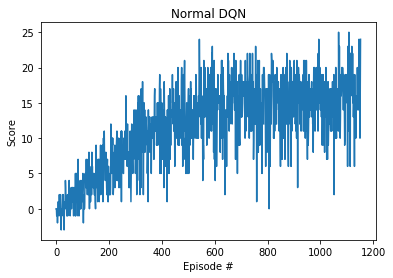

In [8]:
scores = dqn(normal_agent, './checkpoints/checkpoint_normal.pth')
plot_scores(scores, "Normal DQN")

### Double DQN

Creates a double DQN agent, trains it, and plots the scores. The Double DQN algorithm is based on the [Double DQN Paper](https://arxiv.org/abs/1509.06461).

In [ ]:
# double DQN
double_agent = Agent(state_size=banana_env.state_size, action_size=banana_env.action_size, 
                     double_dqn=True, dueling=False, seed=0)

Episode 100	Average Score: 0.52
Episode 200	Average Score: 4.42
Episode 300	Average Score: 7.13
Episode 400	Average Score: 11.77
Episode 452	Average Score: 13.01
Environment solved in 452 episodes!	Average Score: 13.01
Episode 500	Average Score: 14.03
Episode 600	Average Score: 14.81
Episode 700	Average Score: 14.33
Episode 800	Average Score: 15.21
Episode 900	Average Score: 15.52
Episode 961	Average Score: 16.01
Environment 16+ in 961 episodes!	Average Score: 16.01


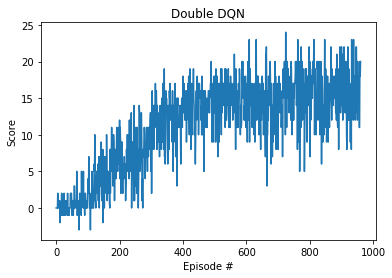

In [9]:
scores = dqn(double_agent, './checkpoints/checkpoint_double.pth')
plot_scores(scores, "Double DQN")

### Dueling DQN

Creates a dueling DQN agent, trains it, and plots the scores. Dueling DQNs were covered in this [paper](https://arxiv.org/abs/1511.06581).

In [ ]:
# dueling DQN
dueling_agent = Agent(state_size=banana_env.state_size, action_size=banana_env.action_size, 
                     double_dqn=False, dueling=True, seed=0)

Episode 100	Average Score: 0.71
Episode 200	Average Score: 3.64
Episode 300	Average Score: 7.15
Episode 400	Average Score: 10.45
Episode 500	Average Score: 11.73
Episode 600	Average Score: 12.98
Episode 601	Average Score: 13.04
Environment solved in 601 episodes!	Average Score: 13.04
Episode 700	Average Score: 14.27
Episode 800	Average Score: 14.96
Episode 900	Average Score: 15.97
Episode 901	Average Score: 16.08
Environment 16+ in 901 episodes!	Average Score: 16.08


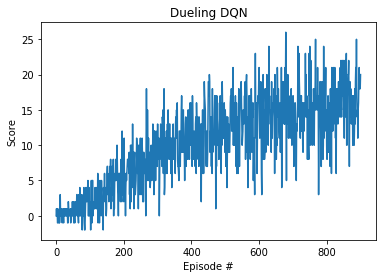

In [10]:
scores = dqn(dueling_agent, './checkpoints/checkpoint_dueling.pth')
plot_scores(scores, "Dueling DQN")

### Dueling + Double DQN

Tests the results with a dueling network and using the second network to choose the max value.

In [ ]:
# dueling + double DQN
double_dueling_agent = Agent(state_size=banana_env.state_size, action_size=banana_env.action_size, 
                     double_dqn=True, dueling=True, seed=0)

Episode 100	Average Score: 1.06
Episode 200	Average Score: 5.14
Episode 300	Average Score: 8.01
Episode 400	Average Score: 10.81
Episode 500	Average Score: 12.76
Episode 503	Average Score: 13.04
Environment solved in 503 episodes!	Average Score: 13.04
Episode 600	Average Score: 14.25
Episode 700	Average Score: 15.15
Episode 800	Average Score: 15.42
Episode 869	Average Score: 16.02
Environment 16+ in 869 episodes!	Average Score: 16.02


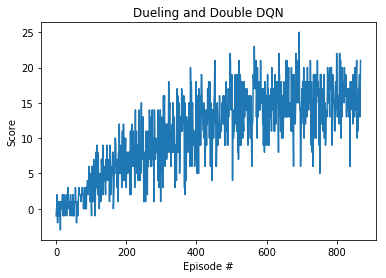

In [11]:
scores = dqn(double_dueling_agent, './checkpoints/checkpoint_dueling_double.pth')
plot_scores(scores, "Dueling and Double DQN")

#### Watch a Smart Agent

In [8]:
def run_smart_agent(agent):
    for i in range(3):
        state = banana_env.reset(False)
        score = 0
        while True:
            next_state, reward, done, _ = banana_env.step(agent.act(state))
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        print("Score: {}".format(score))

In [9]:
normal_agent.qnetwork_online.load_state_dict(torch.load('./checkpoints/checkpoint_normal.pth'))
run_smart_agent(normal_agent)

Score: 16.0
Score: 19.0
Score: 9.0


In [15]:
double_agent.qnetwork_online.load_state_dict(torch.load('./checkpoints/checkpoint_double.pth'))
run_smart_agent(double_agent)

Score: 17.0
Score: 20.0
Score: 13.0


In [16]:
dueling_agent.qnetwork_online.load_state_dict(torch.load('./checkpoints/checkpoint_dueling.pth'))
run_smart_agent(dueling_agent)

Score: 19.0
Score: 21.0
Score: 16.0


In [17]:
double_dueling_agent.qnetwork_online.load_state_dict(torch.load('./checkpoints/checkpoint_dueling_double.pth'))
run_smart_agent(double_dueling_agent)

Score: 17.0
Score: 19.0
Score: 23.0


In [22]:
banana_env.env.close()